In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

## Input of PIV results, red beads masks and aggregate images

In [2]:
# open .h5 file containing piv results.
h5_file_path = "F:/PhD_Franziska/Headon/RedBeads/test_piv/original_red_beads_matrix_piv_test(no_mask)"
with h5py.File(h5_file_path, "r") as h5f:
    U = h5f["U"][:] # shape: frame, rows, columns 
    V = h5f["V"][:]
    M = h5f["M"][:]
    xgrid = h5f["xgrid"][:]
    ygrid = h5f["ygrid"][:]

In [3]:
# open .h5 file of cutted masked red beads images.
red_beads_file_path = "F:/PhD_Franziska/Headon/RedBeads/mask_red_beads_cut1.h5"
with h5py.File(red_beads_file_path, "r") as h5f:
    masked_red_beads = h5f["masked_red_beads"][:]

In [3]:
# open .h5 file for aggregate images and original red beads images
aggregate_file_path = "F:/PhD_Franziska/Headon/RedBeads/subregion_cut1(2).h5"
with h5py.File(aggregate_file_path, "r") as h5f:
    aggregate = h5f["green"][:]
    red_beads = h5f["red"][:]

In [4]:
sub_frame = red_beads[99:130]
sub_frame_aggregate = aggregate[99:130]
sub_frame.shape

(31, 900, 800)

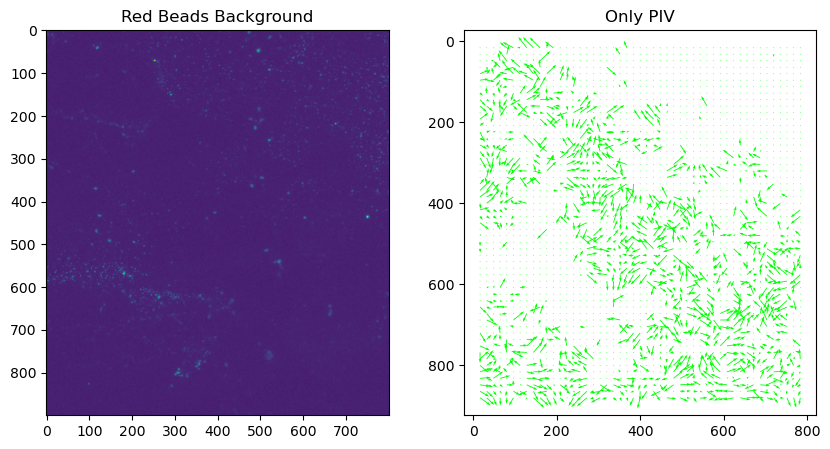

In [5]:
t = 0

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Red Beads Background")
# plt.imshow(sub_frame_aggregate[t])
plt.imshow(sub_frame[t])

plt.subplot(1, 2, 2)
plt.title("Only PIV")
plt.quiver(ygrid[t], xgrid[t], U[t], V[t], color = "lime")
plt.gca().invert_yaxis()
plt.show()

## Time averaging of PIV vector fields

In [6]:
def vector_avg(U, V, M, t, interval):
    # Compute the averaging vectors and their magnitudes at time t. 
    # U, V and M are the total data sets. 
    # Interval determins the averaging interval before and after t.

    if t < interval:
        U_mid = np.median(U[0 : t+interval+1], axis = 0)
        V_mid = np.median(V[0 : t+interval+1], axis = 0)
        # U_mid = np.mean(U[0:t+interval+1], axis = 0)
        # V_mid = np.mean(V[0:t+interval+1], axis = 0)
        print("1")
    elif len(U)-t < interval:
        U_mid = np.median(U[t-interval : len(U)+1], axis = 0)
        V_mid = np.median(V[t-interval : len(U)+1], axis = 0)
        # U_mid = np.mean(U[t-interval:len(U)+1], axis = 0)
        # V_mid = np.mean(V[t-interval:len(U)+1], axis = 0)
        print("2")
    else:
        U_mid = np.median(U[t-interval : t+interval+1], axis = 0)
        V_mid = np.median(V[t-interval : t+interval+1], axis = 0)
        # U_mid = np.median(U[t-interval : t+interval+1], axis = 0)
        # V_mid = np.median(V[t-interval : t+interval+1], axis = 0)
        print("3")

    # Update the M (magnitude matrix)
    M_mid = np.sqrt(U_mid**2 + V_mid**2)
        
    return U_mid, V_mid, M_mid

1


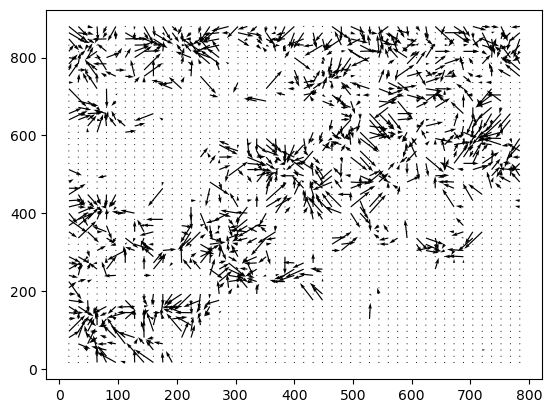

In [17]:
U_mid, V_mid, _ = vector_avg(U, V, M, 5, 15)
plt.quiver(ygrid[0], xgrid[0], U_mid, V_mid)

## Cut the regions that are not covered by skin tissue. Those are NaN in red beads masks. 

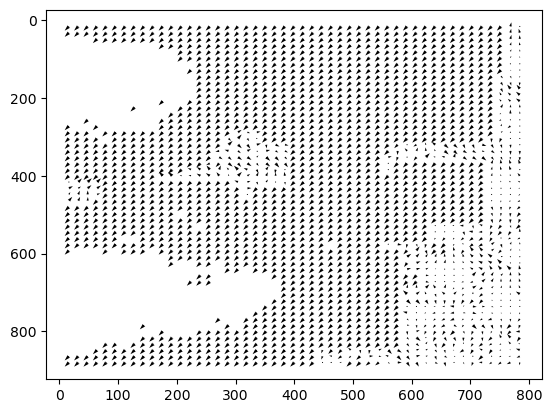

In [7]:
# Alternative 1: Use index from grid matrix, check if the correspoding position has in red beads mask value NaN.
# If the value is NaN, then find out the index of this position in grid matrices. 
# Then set the vector values with this index to NaN. 

xgrid_matrix = xgrid[0]
ygrid_matrix = ygrid[0]
red_bead_mask = sub_frame[0]
U_matrix = U[0]
V_matrix = V[0]

# Find out the index for position from grid matrix which corresponds to NaN in masks. 
for i in range(xgrid_matrix.shape[0]):
    mask_value = red_bead_mask[xgrid_matrix[i,:].astype(int), ygrid_matrix[i,:].astype(int)]
    is_nan = np.isnan(mask_value)
    col_index = np.where(is_nan)[0]
    row_index = np.full(len(col_index), i)

    # Change the vector value with those index to NaN. 
    U_matrix[row_index, col_index] = np.nan
    V_matrix[row_index, col_index] = np.nan

# Plot the cutted vector field.
plt.quiver(ygrid_matrix, xgrid_matrix, U_matrix, V_matrix)
plt.gca().invert_yaxis()

In [8]:
# Write the above processing as function.
def piv_mask(t, xgrid_set, ygrid_set, red_bead_set, U, V): 
    
    xgrid_matrix = xgrid[t]
    ygrid_matrix = ygrid[t]
    red_bead_mask = red_bead_set[t]
    U_matrix = U[t]
    V_matrix = V[t]
    
    # Find out the index for position from grid matrix which corresponds to NaN in masks. 
    for i in range(xgrid_matrix.shape[0]):
        mask_value = red_bead_mask[xgrid_matrix[i,:].astype(int), ygrid_matrix[i,:].astype(int)]
        is_nan = np.isnan(mask_value)
        col_index = np.where(is_nan)[0]
        row_index = np.full(len(col_index), i)
    
        # Change the vector value with those index to NaN. 
        U_matrix[row_index, col_index] = np.nan
        V_matrix[row_index, col_index] = np.nan
        
    return ygrid_matrix, xgrid_matrix, U_matrix, V_matrix

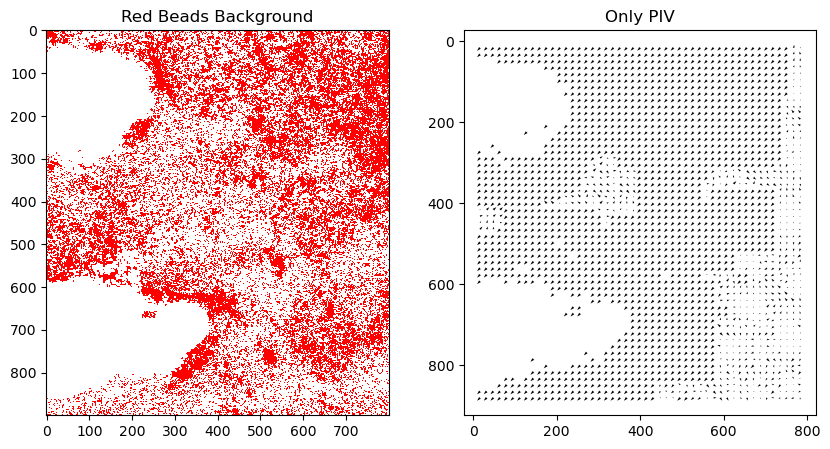

In [10]:
ygrid_matrix, xgrid_matrix, U_matrix, V_matrix = piv_mask(0, xgrid, ygrid, sub_frame, U, V)

t = 0

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Red Beads Background")
plt.imshow(sub_frame[t], cmap= ListedColormap(["white", "red"]))

plt.subplot(1, 2, 2)
plt.title("Only PIV")
plt.quiver(ygrid_matrix, xgrid_matrix, U_matrix, V_matrix)
plt.gca().invert_yaxis()
plt.show()

In [83]:
# Alternative 2: Get all index of NaN in mask. Find if the index appears in grid matrix.
# If appears, find out the position in grid matrices.
# Set the vector values with those positions to NaN. 

# xgrid_matrix = xgrid[0]
# ygrid_matrix = ygrid[0]
# red_bead_mask = sub_frame[0]
# U_matrix = U[0]
# V_matrix = V[0]

# # Find out the positions of NaN in red bead mask 
